# Is Centrality a guide to Bowl Eligibility in College Football


#In this project we ask if the centrality of team has any impact on a NCAA Division I Football Bowl Subdivision (FBS) teams bowl eligibility. To answer this question I have identified a rather interesting data set that contains the full 2019 Collage Foot Ball results. Each row of the data set contains the date of the game, the two teams that played and each team's score. The original data can be found on his website at https://www.sports-reference.com/cfb/years/2019-schedule.html#schedule::none
The original data set is not well formated for machine reading .To facillitate using the data I did some basica data cleaning and posted the data on my own GitHub site which can be found at https://raw.githubusercontent.com/rajank17/Data620/master/2018FBSData_1.txt. 
This dataset is in comma separated format and contains a header on the third line with the first two lines being the authors attribution.
The code below imports the 2019 Collage season football dataand begins the construction of a new data set that we have called record. This data set contains all of the teams that played in the 2019 season along with their wins, losses, winning percentage, bowl eligibility, and the columns for the various centrality measures. 
How is a team bowl eligible? 
A Collage team is eligible to play in a postseason 'bowl game' if they have compiled a winning percentage of at least 50% or if they are from a large conference and win their conference championship game. 
For this analysis we will be using the first criterion as there has yet to be a team that made it to their conference championship game without winning at least half of their games. There is also an odd edge case that we are not including in this analysis. A team may become bowl eligible with a win loss record of less than 50% if there are not enough teams with a winning percentage above 50% to fill all of the games. 
This does happen occasionally but it does not happen in this data set.

In [81]:
# Loading the packages needed for this project
%matplotlib inline
import networkx as nx
import pandas as pd
from scipy import stats
import matplotlib
matplotlib.style.use('ggplot')
from __future__ import division

# Loading the Data
The data set contains the entire seasons including the bowl games that are played at the end of the season. We start by subsetting our data to only include games that are played before the end of the regular season on December 14th 2019 with the Army - Navy game.

In [82]:
# Reading the data into a pandas data frame
season = pd.read_csv('https://raw.githubusercontent.com/rajank17/Data620/master/2018FBSData_1.txt', header = 2)

# Convert the Date columns to actual date format
season['Date'] = pd.to_datetime(season['Date'], infer_datetime_format=True)

In [83]:
# Quick look at the data
season.head()

,Date,Team1,Team1_Score,Team2,Team2_Score,Unnamed: 5
0,2019-08-24,Florida,24,Miami(FL),20,NaN
1,2019-08-24,Hawaii,45,Arizona,38,NaN
2,2019-08-24,Alabama-Birmingham,24,AlabamaState,19,NaN
3,2019-08-24,ArizonaState,30,KentState,7,NaN
4,2019-08-24,BowlingGreenState,46,MorganState,3,NaN


In [84]:
# Generating the data frame for the regular season games.(Regular season ends with the Army-Navy on 12/11/2010)
reg_season = season[season.Date <= '2019-12-14']
reg_season.tail()

,Date,Team1,Team1_Score,Team2,Team2_Score,Unnamed: 5
843,2019-08-24,Memphis,29,Cincinnati,24,NaN
844,2019-08-24,Miami(OH),26,CentralMichigan,21,NaN
845,2019-08-24,OhioState,34,Wisconsin,21,NaN
846,2019-08-24,Oklahoma,30,Baylor,23,NaN
847,2019-08-24,Navy,31,Army,7,NaN


# Building the Record Data
Now that we have our Collage foot ball regular season results we can start building our data set that stores our list of teams (Team), their wins (Wins), losses (Loss), games played (Played), win percentage (WLP), bowl eligibility (Bowl_Eligible), degree centrality (degcen), eigenvector centrality (eigencen), closeness centrality (closecen), and betweenness centrality (betweencen).

In [85]:
# Generating a list of all of the teams in both lists.
team1_list = set(reg_season.Team1.unique())
team2_list = set(reg_season.Team2.unique())
len(team1_list) # Number of unique teams in the Team1 column


132

In [86]:
# Joining the two columns to get a unique list of all teams in the data set
teams = list(team1_list.union(team2_list))
len(teams) # It appears that the Team1 column contains all of the teams in the data set.

217

In [87]:
# Generating a data frame to contain the wins and losses for each team
teams.sort()
record = pd.DataFrame({'Team':teams})
record['Win'] = 0
record['Loss'] = 0
record['Played'] = 0
record['WLP'] = 0
record['Bowl_Eligible'] = 'No' #Setting all teams to ineligible
record['degcen'] = 0
record['eigencen'] = 0
record['closecen'] = 0
record['betweencen'] = 0
record.head()

,Team,Win,Loss,Played,WLP,Bowl_Eligible,degcen,eigencen,closecen,betweencen
0,AbileneChristian,0,0,0,0,No,0,0,0,0
1,AirForce,0,0,0,0,No,0,0,0,0
2,Akron,0,0,0,0,No,0,0,0,0
3,Alabama,0,0,0,0,No,0,0,0,0
4,Alabama-Birmingham,0,0,0,0,No,0,0,0,0


The code below parses the regular season games and fills in the record data frame for the 217 teams that are in data set. Around a third of the teams in this data set are from the lower NCAA Football Championship Subdivision (FCS). These FCS teams will be removed before we do our final analysis given that they are ineligible to play in a bowl game but they do count towards an FBS teams win-loss record so they will not be removed until the end.

In [88]:
# Building the Wins and Loses Columns along with the total number of games played.
for index, row in reg_season.iterrows():
    if row['Team1_Score'] > row['Team2_Score']:
        record.loc[record['Team'] == row['Team1'], 'Win'] = record.loc[record['Team'] == row['Team1'], 'Win'] + 1
        record.loc[record['Team'] == row['Team1'], 'Played'] = record.loc[record['Team'] == row['Team1'], 'Played'] + 1
        record.loc[record['Team'] == row['Team2'], 'Loss'] = record.loc[record['Team'] == row['Team2'], 'Loss'] + 1
        record.loc[record['Team'] == row['Team2'], 'Played'] = record.loc[record['Team'] == row['Team2'], 'Played'] + 1
    if row['Team1_Score'] < row['Team2_Score']:
        record.loc[record['Team'] == row['Team1'], 'Loss'] = record.loc[record['Team'] == row['Team1'], 'Loss'] + 1
        record.loc[record['Team'] == row['Team1'], 'Played'] = record.loc[record['Team'] == row['Team1'], 'Played'] + 1
        record.loc[record['Team'] == row['Team2'], 'Win'] = record.loc[record['Team'] == row['Team2'], 'Win'] + 1
        record.loc[record['Team'] == row['Team2'], 'Played'] = record.loc[record['Team'] == row['Team2'], 'Played'] + 1

# Generating the winning percentage or each team.
record['WLP'] = record['Win']/record['Played']

# Calculating bowl eligibility for each team.
for index, row in record.iterrows():
    if row['WLP'] >= 0.5:
        record.loc[record['Team'] == row['Team'], 'Bowl_Eligible'] = 'Yes'

In [89]:
record.head()

,Team,Win,Loss,Played,WLP,Bowl_Eligible,degcen,eigencen,closecen,betweencen
0,AbileneChristian,0,2,2,0.000000,No,0,0,0,0
1,AirForce,10,2,12,0.833333,Yes,0,0,0,0
2,Akron,0,12,12,0.000000,No,0,0,0,0
3,Alabama,10,2,12,0.833333,Yes,0,0,0,0
4,Alabama-Birmingham,9,4,13,0.692308,Yes,0,0,0,0


# Generating the Graph
Now that the data is containing each team's record construct a graph so that computation of the different measures of centrality os accomplished and add those two the data set. 
When this analysis began we were unsure of what if any results we would find in the data. We picked this data set to see if there might be any effect on a team's likelihood of becoming bowl eligible based on their connections with other teams. 
The thought that there might be connection with the teams with high betweenness centrality and bowl eligibility although unsure of the direction of the connection. 
Teams that tend to play a lot of out of conference games and have a higher betweenness centrality may either do this because they are high profile teams that tend to make the playoffs or they are teams that are scheduled because they are considered to be relatively easy wins and don't tend to make the playoffs.

In [90]:
# Generating a network x from the edge list stored in pandas.
G = nx.from_pandas_dataframe(reg_season, 'Team1', 'Team2')

In [91]:
# Calculating the number of teams
nx.number_of_nodes(G)

217

In [92]:
# Calculating the number of games played.
nx.number_of_edges(G)

842

In [93]:
# Adding the Bowl Eligibility attribute to each of the nodes.
for n in G.nodes():
    G.node[n]['Bowl_Eligible'] = 'No'
    G.node[n]['vis'] = {'color': {'r': 255, 'g': 0, 'b': 0, 'a': 0}}
for index, row in record.iterrows():
    G.node[row['Team']]['Bowl_Eligible'] = row['Bowl_Eligible']
    if row['Bowl_Eligible'] == 'Yes':
        G.node[row['Team']]['vis'] = {'color': {'r': 0, 'g': 0, 'b': 255, 'a': 0}}
        

Now that we have created our graph we can calculate the various centrality measures for each of the nodes as described above. We do note that the degree centrality is simply the number of games that each team played and therefore we don't expect to see much difference between bowl eligibility based off of this measure. Given this we have elected to calculate a number of other centrality measures as well to discover if any of them have a significant impact on the bowl eligibility.

In [94]:
# Calculating the degree of each of the teams and storing this in our record data frame
# This will be the same as the number of games played
deg = nx.degree(G) 
eig = nx.eigenvector_centrality(G)
clo = nx.closeness_centrality(G)
btw = nx.betweenness_centrality(G)
for index, row in record.iterrows():
    record.loc[record['Team'] == row['Team'], 'degcen'] = deg[row['Team']]
    record.loc[record['Team'] == row['Team'], 'eigencen'] = eig[row['Team']]
    record.loc[record['Team'] == row['Team'], 'closecen'] = clo[row['Team']]
    record.loc[record['Team'] == row['Team'], 'betweencen'] = btw[row['Team']]

In [95]:
record.head()

,Team,Win,Loss,Played,WLP,Bowl_Eligible,degcen,eigencen,closecen,betweencen
0,AbileneChristian,0,2,2,0.000000,No,2,0.014509,0.288770,0.000149
1,AirForce,10,2,12,0.833333,Yes,12,0.084215,0.342857,0.016067
2,Akron,0,12,12,0.000000,No,12,0.095566,0.357025,0.011743
3,Alabama,10,2,12,0.833333,Yes,12,0.078930,0.355848,0.015171
4,Alabama-Birmingham,9,4,13,0.692308,Yes,13,0.091693,0.362416,0.017413


Now that full data set is constructed ,time to this down to just the teams that have played more than 9 games. This ensures that we get only the FBS teams for our final analysis.

In [96]:
# Removing all of the teams that played less than a full season
FBS = record.loc[record['Played'] >= 9]
FBS.head()

,Team,Win,Loss,Played,WLP,Bowl_Eligible,degcen,eigencen,closecen,betweencen
1,AirForce,10,2,12,0.833333,Yes,12,0.084215,0.342857,0.016067
2,Akron,0,12,12,0.000000,No,12,0.095566,0.357025,0.011743
3,Alabama,10,2,12,0.833333,Yes,12,0.078930,0.355848,0.015171
4,Alabama-Birmingham,9,4,13,0.692308,Yes,13,0.091693,0.362416,0.017413
8,AppalachianState,12,1,13,0.923077,Yes,12,0.078246,0.348950,0.014317


# Testing for Differences in Centrality based on Bowl Eligibility
Now that the centrality measures for the various teams are calculated we can construct a T-test to determine if there is a difference between the average centrality score for bowl eligible teams or if they are the same. We will also construct histograms for each of the to see if there are any interesting or unusual patterns in the data.
Degree Centrality
$H_0 :There is no difference in the average degree centrality for bowl eligible teams vs teams that are not bowl eligible.
$H_A :There is a difference in the degree centrality.
From our T-test we find a test statistic of 2.197 and an p-value of 0.029. Therefore we fail to reject the null hypothesis and conclude that there is no difference in degree centrality between the two groups.

Ttest_indResult(statistic=2.196940145524359, pvalue=0.029824859853229347)

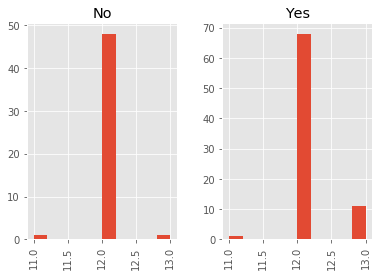

In [97]:
# Testing for differences in degree centrality based on bowl elligibility
FBS['degcen'].hist(by = FBS['Bowl_Eligible'])
stats.ttest_ind(FBS.loc[FBS['Bowl_Eligible'] == 'Yes', 'degcen'],
                FBS.loc[FBS['Bowl_Eligible'] == 'No', 'degcen']) # No significant Difference

# Eigenvector Centrality
$H_0 :There is no difference in the average eigenvector centrality for bowl eligible teams vs teams that are not bowl eligible.
$H_A :There is a difference in the eigenvector centrality.
From our T-test we find a test statistic of .214 and an p-value of 0.831 Therefore we fail to reject the null hypothesis and conclude that there is no difference in eigenvector centrality between the two groups. However we do also note that at an alpha level of "0.1" we would have a significant difference. This may be an interesting result to further explore in other years data.

Ttest_indResult(statistic=0.21409381371318376, pvalue=0.8308145762696025)

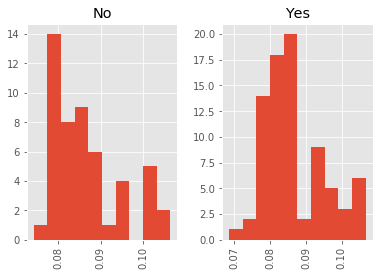

In [98]:
# Testing for differences in eigenvalue centrality based on bowl eligibility
FBS['eigencen'].hist(by = FBS['Bowl_Eligible'])
stats.ttest_ind(FBS.loc[FBS['Bowl_Eligible'] == 'Yes', 'eigencen'],
                FBS.loc[FBS['Bowl_Eligible'] == 'No', 'eigencen']) # No significant Difference

# Closness Centrality
$H_0 :There is no difference in the average closness centrality for bowl eligible teams vs teams that are not bowl eligible.
$H_A :There is a difference in the closness centrality.
From our T-test we find a test statistic of 0.14 and an p-value of 0.886 Therefore we fail to reject the null hypothesis and conclude that there is no difference in closness centrality between the two groups.

Ttest_indResult(statistic=0.14314719695275505, pvalue=0.8863990323061233)

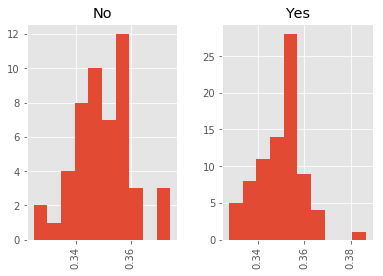

In [99]:
# Testing for differences in closness centrality based on bowl eligibility
FBS['closecen'].hist(by = FBS['Bowl_Eligible'])
stats.ttest_ind(FBS.loc[FBS['Bowl_Eligible'] == 'Yes', 'closecen'],
                FBS.loc[FBS['Bowl_Eligible'] == 'No', 'closecen']) # No significant Difference

# Betweenness Centrality
$H_0 :There is no difference in the average betweenness centrality for bowl eligible teams vs teams that are not bowl eligible.
$H_A :There is a difference in the betweenness centrality.
From our T-test we find a test statistic of .6637 and an p-value of 0.5080. Therefore we reject the null hypothesis and conclude that there is a difference in betweenness centrality between the two groups. We also can see from our histograms that teams with higher betweenness ratings are more likely to make a bowl game.

Ttest_indResult(statistic=-0.6637975245292591, pvalue=0.5080137729957861)

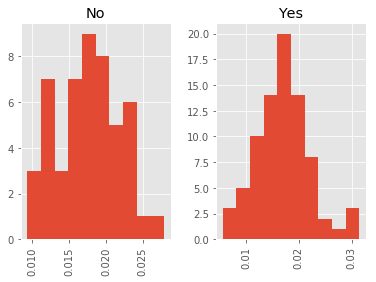

In [100]:
# Testing for differences in betweenness centrality based on bowl eligibility
FBS['betweencen'].hist(by = FBS['Bowl_Eligible'])
stats.ttest_ind(FBS.loc[FBS['Bowl_Eligible'] == 'Yes', 'betweencen'],
                FBS.loc[FBS['Bowl_Eligible'] == 'No', 'betweencen']) # Significant Difference at alpha = 0.05

# Drawing the Graph
The analysis of the data is than visulized by constructing the graph for the regular season. We start off by trimming the teams away that do not play enough games in the season.We start by constructing the graph in networkX but we can see that networkX lacks the ability to draw the graph in an easy to see format so we will also construct the graph in Gephi and import the image.

In [101]:
# Function to trim the edges for non-FBS teams
def trim_degrees(g, degree = 1):
    g2 = g.copy()
    d = nx.degree(g2)
    for n in list(g2.nodes()):
        if d[n] <= degree:
            g2.remove_node(n)
    return g2

In [102]:
core = trim_degrees(G, degree = 3)

/Users/rajans/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:565: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


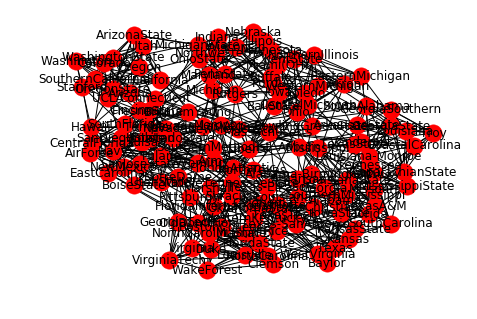

In [103]:
nx.draw(core, with_labels=True)

# Conclusions
When this project was chosen there was no real expectations about what would be the outcome of this analysis. 
It was simply an interesting data set that about football, Ultimately the analysis unearthed some interesting information, specifically that the betweenness centrality measure is a statistically significant predictor of a team's bowl eligibility. The value of the test statistic and the histograms lead us to believe that a team with a higher betweenness centrality has a higher chance to be bowl eligible. 
This implies that teams who serve as bridges between the different clusters, or FBS conferences, are more likely to be bowl eligible. 
This is an interesting and unexpected finding and warrants further study looking to see if this holds for other years. It was discovered that the eigenvector centrality also may have an impact on the bowl eligibility of teams. This is an interesting factor since no nodes are really any more central than others. However any team that played in a conference championship game had a 13 game season and we see that a number of bowl eligible teams came out of conferences that have a conference championship. This is a topic that would make a good case study.